## Importing libraries we will need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Import the data

In [2]:
data = pd.read_csv('data.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Visualizaion

### The missing values

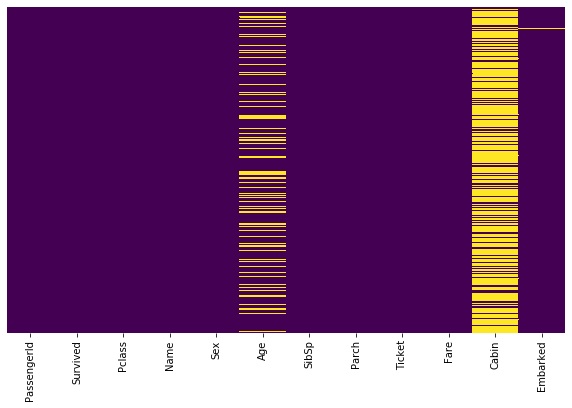

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### The count of survived and not survied

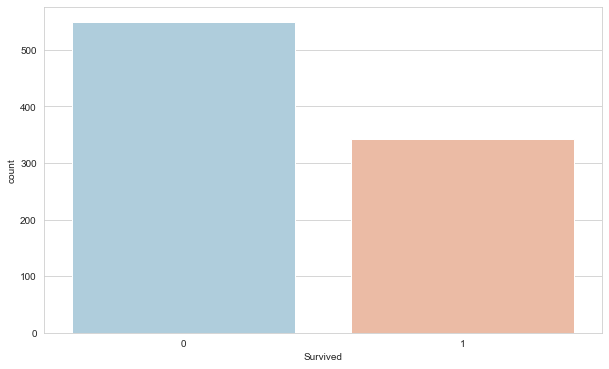

In [7]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=data,palette='RdBu_r')

### The count of male and female who survived and not survived

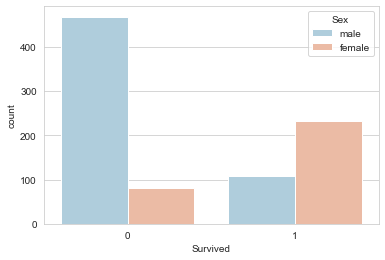

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=data,palette='RdBu_r')

### What is Pclass of who survived and not survived

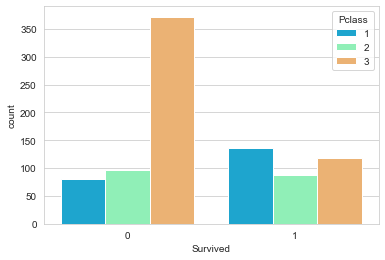

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=data,palette='rainbow')

### The count of SibSip

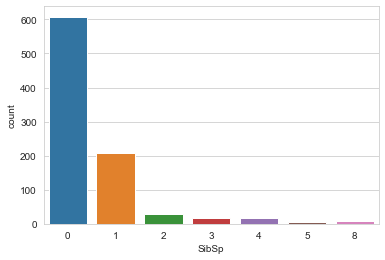

In [10]:
sns.countplot(x='SibSp',data=data)

### Dropping columns we will not use

In [11]:
X = data.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'])
y = data['Survived']

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [12]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## Data preprocessing

### Data preprocessing for numerical data

In [13]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [14]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ('imputer', SimpleImputer(strategy='mean'))
])

In [15]:
X_num = pd.DataFrame(num_pipeline.fit_transform(data), columns=["Age", "SibSp", "Parch", "Fare"])

### Data preprocessing for categorical data

In [16]:
sex = pd.get_dummies(data['Sex'], drop_first=True)
embarked = pd.get_dummies(data['Embarked'], drop_first=True)

### Joining the clean data

In [17]:
X_preprocess = X_num.join([sex, embarked, data['Pclass']])

In [18]:
X_preprocess.head()

,Age,SibSp,Parch,Fare,male,Q,S,Pclass
0,22.0,1.0,0.0,7.2500,1,0,1,3
1,38.0,1.0,0.0,71.2833,0,0,0,1
2,26.0,0.0,0.0,7.9250,0,0,1,3
3,35.0,1.0,0.0,53.1000,0,0,1,1
4,35.0,0.0,0.0,8.0500,1,0,1,3


In [19]:
X_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     891 non-null    float64
 1   SibSp   891 non-null    float64
 2   Parch   891 non-null    float64
 3   Fare    891 non-null    float64
 4   male    891 non-null    uint8  
 5   Q       891 non-null    uint8  
 6   S       891 non-null    uint8  
 7   Pclass  891 non-null    int64  
dtypes: float64(4), int64(1), uint8(3)
memory usage: 37.5 KB


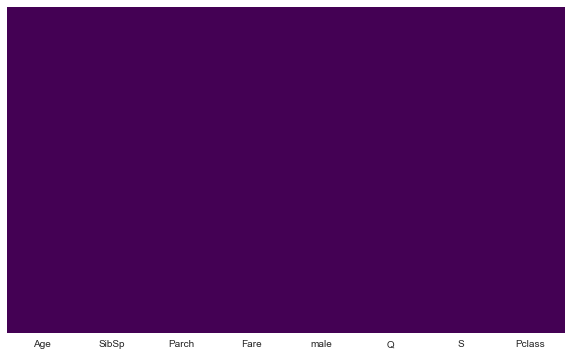

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_preprocess.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Scaling the data

In [21]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_preprocess.astype(np.float64))

## Spliting data into train set and test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [23]:
svm_clf = SVC(random_state=42, C=1)

cross_val_score(svm_clf, X_scaled, y, cv=3, scoring="accuracy").mean()

0.8271604938271605

### Evaluating the model

In [24]:
svm_clf.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [25]:
prediction_train = svm_clf.predict(X_test)

print(svm_clf.score(X_test, y_test))
print('\n')
print(classification_report(y_test, prediction_train))

0.8100558659217877


              precision    recall  f1-score   support

           0       0.81      0.89      0.85       105
           1       0.81      0.70      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



## Fiting the model

In [26]:
svm_clf.fit(X_scaled, y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

## Working on the test data

In [27]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [29]:
X_test = test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [30]:
num_test_pipeline = num_pipeline.fit_transform(X_test)

X_num_test = pd.DataFrame(num_test_pipeline, columns=["Age", "SibSp", "Parch", "Fare"])

X_num_test.head()

,Age,SibSp,Parch,Fare
0,34.5,0.0,0.0,7.8292
1,47.0,1.0,0.0,7.0000
2,62.0,0.0,0.0,9.6875
3,27.0,0.0,0.0,8.6625
4,22.0,1.0,1.0,12.2875


In [31]:
sex_test = pd.get_dummies(test['Sex'], drop_first=True)
embarked_test = pd.get_dummies(test['Embarked'], drop_first=True)

In [32]:
test_preprocess = X_num_test.join([sex_test, embarked_test, test['Pclass']])

test_preprocess.head()

,Age,SibSp,Parch,Fare,male,Q,S,Pclass
0,34.5,0.0,0.0,7.8292,1,1,0,3
1,47.0,1.0,0.0,7.0000,0,0,1,3
2,62.0,0.0,0.0,9.6875,1,1,0,2
3,27.0,0.0,0.0,8.6625,1,0,1,3
4,22.0,1.0,1.0,12.2875,0,0,1,3


In [33]:
test_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     418 non-null    float64
 1   SibSp   418 non-null    float64
 2   Parch   418 non-null    float64
 3   Fare    418 non-null    float64
 4   male    418 non-null    uint8  
 5   Q       418 non-null    uint8  
 6   S       418 non-null    uint8  
 7   Pclass  418 non-null    int64  
dtypes: float64(4), int64(1), uint8(3)
memory usage: 17.7 KB


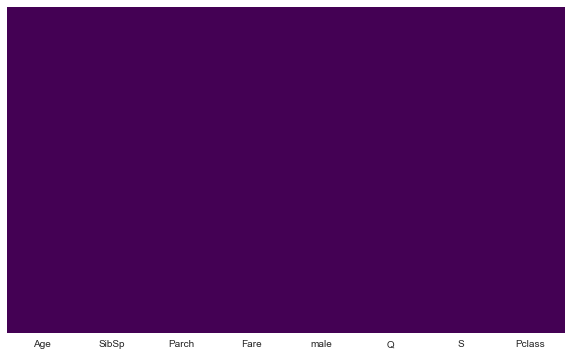

In [34]:
plt.figure(figsize=(10, 6))
sns.heatmap(test_preprocess.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [35]:
test_scaled = scaler.transform(test_preprocess.astype(np.float64))

In [36]:
prediction = svm_clf.predict(test_scaled)

In [37]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': prediction})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [38]:
submission = pd.read_csv('my_submission.csv')
submission.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.313397
std,120.810458,0.464430
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000
